# Import necessary libraries
SAFEP_parse.py contains all the functions and library calls necessary to run the notebook
# Required libraries:
- numpy
- pandas
- matplotlib
- alchemlyb (pip install git+https://github.com/alchemistry/alchemlyb)
- natsort (for sorting file names)
- glob (for unix-like file paths)



# IMPORTANT: Make sure the temperature (set below) matches the temperature you used to run the simulations.

In [1]:
from AFEP_parse import *
plt.rcParams['figure.dpi'] = 150

In [2]:
import os

In [3]:
path='/u2/home_u2/ems363/Documents/ELIC_DCDs_Analyses/MembraneDecoupling/antiflipping/Membrane_211/pctopg/Strat1_2/'
filename='*.fep*'
fepoutFiles = glob(path+filename)
temperature = 303.15
RT = 0.00198720650096 * temperature # ca. 0.59kcal/mol
totalSize = 0
for file in fepoutFiles:
    totalSize += os.path.getsize(file)
print(f"Will process {len(fepoutFiles)} fepout files.\nTotal size:{np.round(totalSize/10**9, 2)}GB")

Will process 41 fepout files.
Total size:0.04GB


In [4]:
fepoutFiles = natsorted(fepoutFiles)
maxSize = 10**9 #Don't use the alchemlyb parser if larger than this size. (bytes)
decorrelate = True
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

# For large data sets: read, decorrelate, save
This reduces RAM requirements between reading and decorrelating

Remember: pickles are not future-proof and should not be used for long-term data storage

In [5]:
from alchemlyb.preprocessing import subsampling

In [6]:
if totalSize>maxSize:
    method = 'dE'
    affix = f'decorrelated_{method}'

    pickles = []
    idx = 0

    for file in tqdm(fepoutFiles):
        df = readFiles([file])
        u_nk = u_nk_fromDF(df, temperature, 0, warnings=False)

        groups = u_nk.groupby('fep-lambda')
        decorr = pd.DataFrame([])
        for key, group in groups:
            test = subsampling.decorrelate_u_nk(group, method)
            decorr = decorr.append(test)
        u_nk = decorr
        pickle = f"{path}{affix}{idx:03d}.pkl"
        u_nk.to_pickle(pickle)
        pickles.append(pickle)
        idx +=1
        
    pickleDFs = []
    for pickle in pickles:
        pickleDFs.append(pd.read_pickle(pickle))

    u_nk = pd.concat(pickleDFs)

In [7]:
#u_nk = u_nk.drop(0.975, axis=1) #to remove incomplete windows e.g. when changing lambda resolutions

# Demonstration of equivalence between the above and below methods

In [8]:
## Demonstrate that AFEP readFiles+u_nk_fromDF is identical to namd.extract_u_nk
## readFiles is more space efficient and can handle single files. Only reads each file once. Less input validation than alchemlyb.namd.
#u_nk_target = namd.extract_u_nk(fepoutFiles[0:5], temperature)
#df = readFiles(fepoutFiles[0:5])
#u_nk_test = u_nk_fromDF(df, temperature, 10000)
#np.all(u_nk_target.fillna(100)==u_nk_test.fillna(100))

# Small data sets can be read and decorrelated sequentially, if desired
See Shirts and Chodera (2008) for more details

"Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177

In [9]:
if totalSize < maxSize:
    from alchemlyb.preprocessing import subsampling

    u_nk = namd.extract_u_nk(fepoutFiles, temperature)

    if decorrelate:
        method = 'dE'
        affix = f'decorrelated_{method}'
        groups = u_nk.groupby('fep-lambda')
        decorr = pd.DataFrame([])
        for key, group in groups:
            test = subsampling.decorrelate_u_nk(group, method)
            decorr = decorr.append(test)
        u_nk = decorr
    else:
        affix = 'unprocessed'

else:
    print(f"Warning: The files you are trying to read are quite large. Total size={totalSize}. Try reading and decorrelating (above) or change the maxSize parameter.")

         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time').duplicated('time').any()
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:133: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time

# Carry out MBAR Fitting and Analyses

In [10]:
u_nk = u_nk.sort_index(level=1)

In [11]:
bar = BAR()
bar.fit(u_nk)

BAR()

# Extract key features from the MBAR fitting and get ΔG
Note: alchemlyb operates in units of kT by default. We multiply by RT to conver to units of kcal/mol.

In [12]:
l, l_mid, f, df, ddf, errors = get_MBAR(bar)
changeAndError = f'\u0394G = {np.round(f.iloc[-1]*RT, 1)}\u00B1{np.round(errors[-1], 3)} kcal/mol'
print(changeAndError)

ΔG = -17.6±0.362 kcal/mol


# Plot the change in free energy based on MBAR estimates

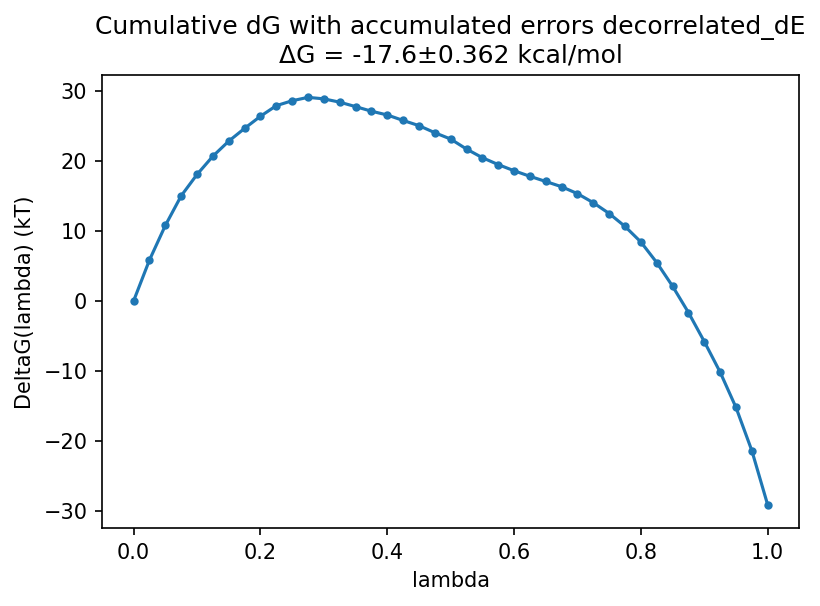

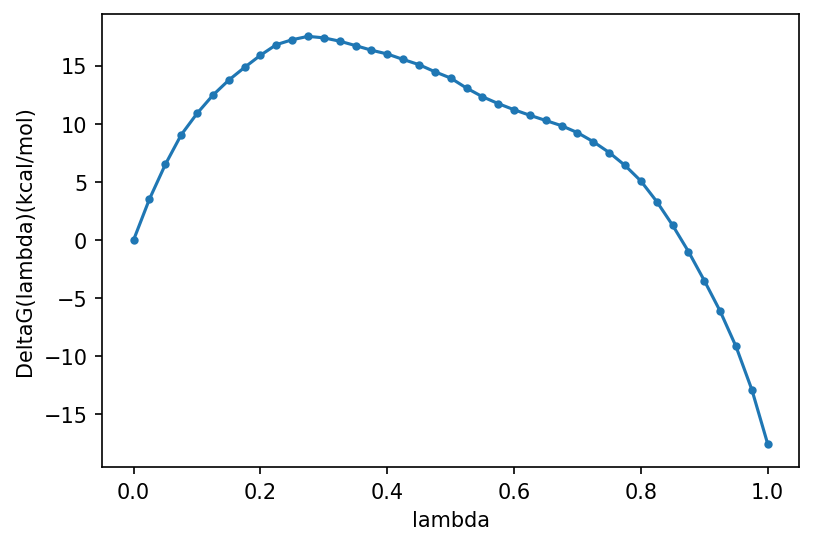

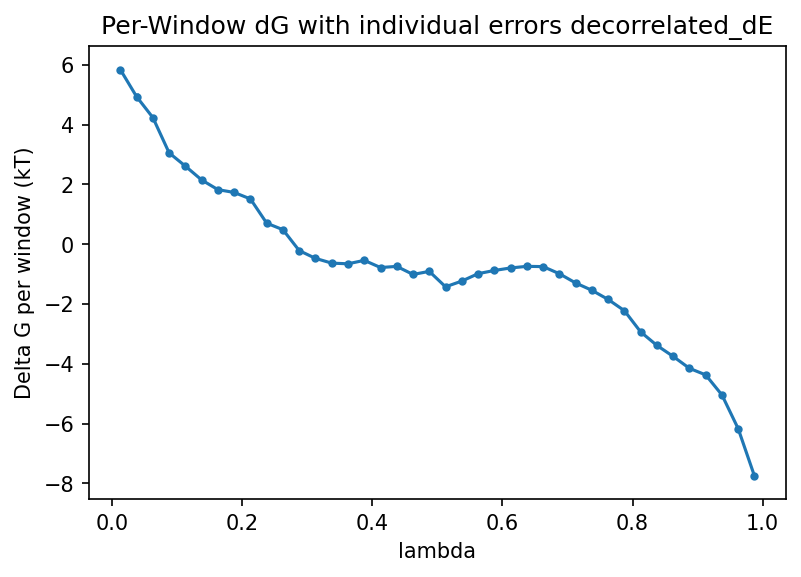

In [13]:
# Cumulative change in kT
plt.errorbar(l, f, yerr=errors, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda) (kT)')
plt.title(f'Cumulative dG with accumulated errors {affix}\n{changeAndError}')
plt.savefig(f'{path}dG_cumulative_kT_{affix}.png', dpi=600)
plt.show()

# Cumulative change in kcal/mol
plt.errorbar(l, f * RT, yerr=errors*RT, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda)(kcal/mol)')
plt.savefig(f'{path}dG_cumulative_kcal_per_mol_{affix}.png', dpi=600)
plt.show()

# Per-window change in kT
plt.errorbar(l_mid, df, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.title(f'Per-Window dG with individual errors {affix}')
plt.savefig(f'{path}dG_{affix}.png', dpi=600)
plt.show()


# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

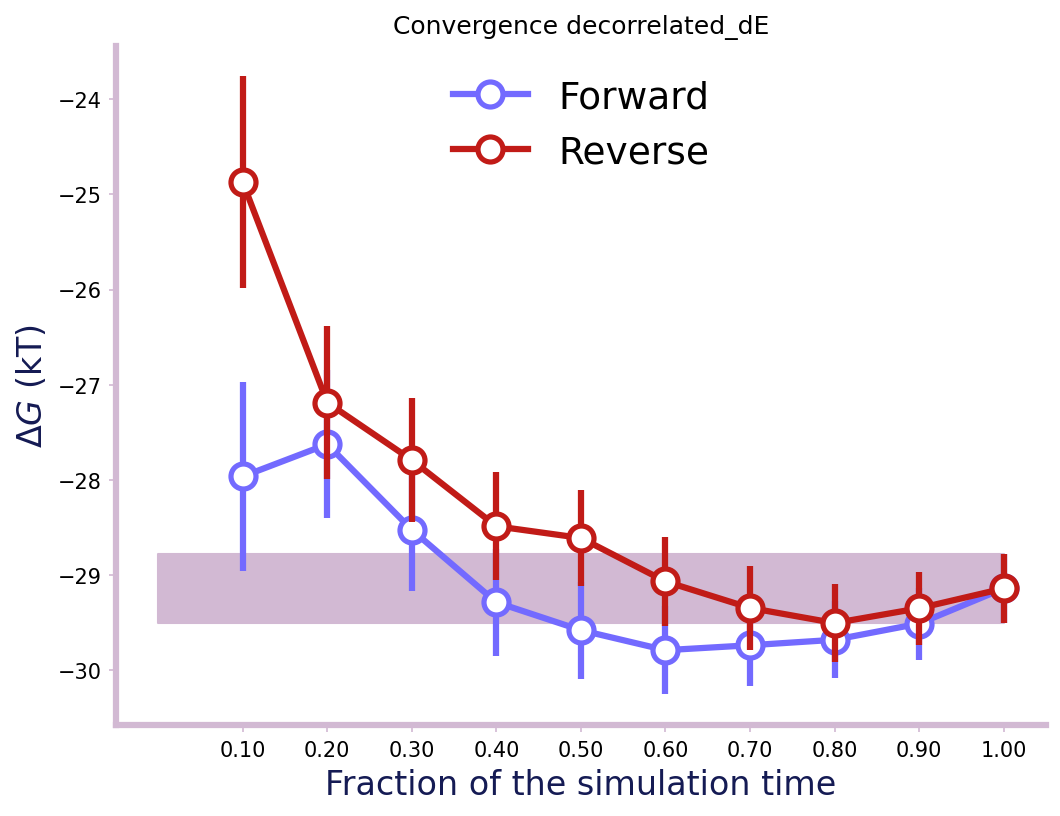

In [14]:
convergence_plot(u_nk, l)
plt.title(f'Convergence {affix}')
plt.savefig(f'{path}convergence_{affix}.png', dpi=600)

# Use an exponential estimator to assess residual discrepancies and check for hysteresis

In [15]:
l, l_mid, dG_f, dG_b = get_EXP(u_nk)

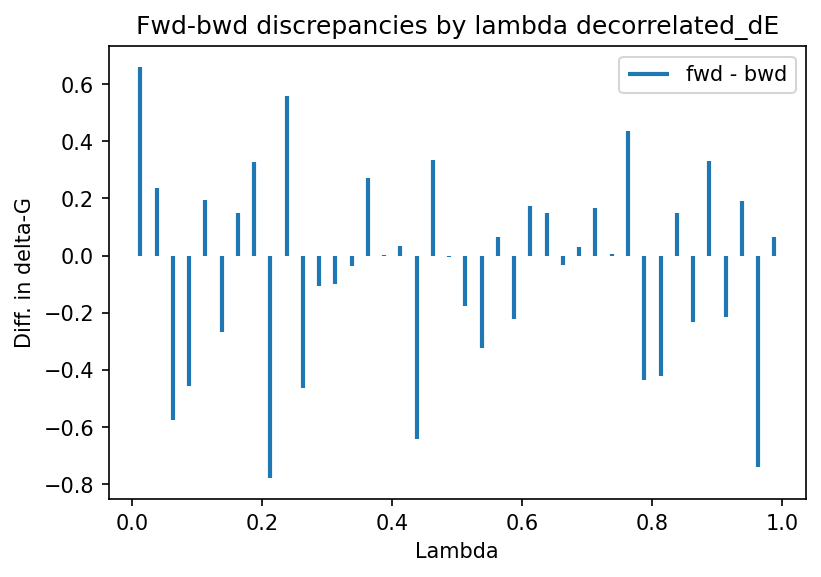

In [16]:
plt.vlines(l_mid, np.zeros(len(l_mid)), dG_f + np.array(dG_b), label="fwd - bwd", linewidth=2)

plt.legend()
plt.title(f'Fwd-bwd discrepancies by lambda {affix}')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G')
plt.savefig(f'{path}discrepancies_{affix}.png', dpi=600)

# OPTIONAL: Estimate and plot the Cumulative Density function (CDF) for the differences shown above.

In [17]:

diff = dG_f + np.array(dG_b)
diff.sort()
X = diff
Y = np.arange(len(X))/len(X)

#fit a normal distribution to the existing data
#fitted = norm.fit(X)



In [18]:
from scipy.special import erfc
from scipy.optimize import curve_fit as scipyFit
from scipy.stats import skew
#Wrapper for fitting the normal CDF
def cumFn(x, m, s):
    r = norm.cdf(x, m, s)
    return r

def pdfFn(x,m,s):
    r = norm.pdf(x,m,s)
    return r

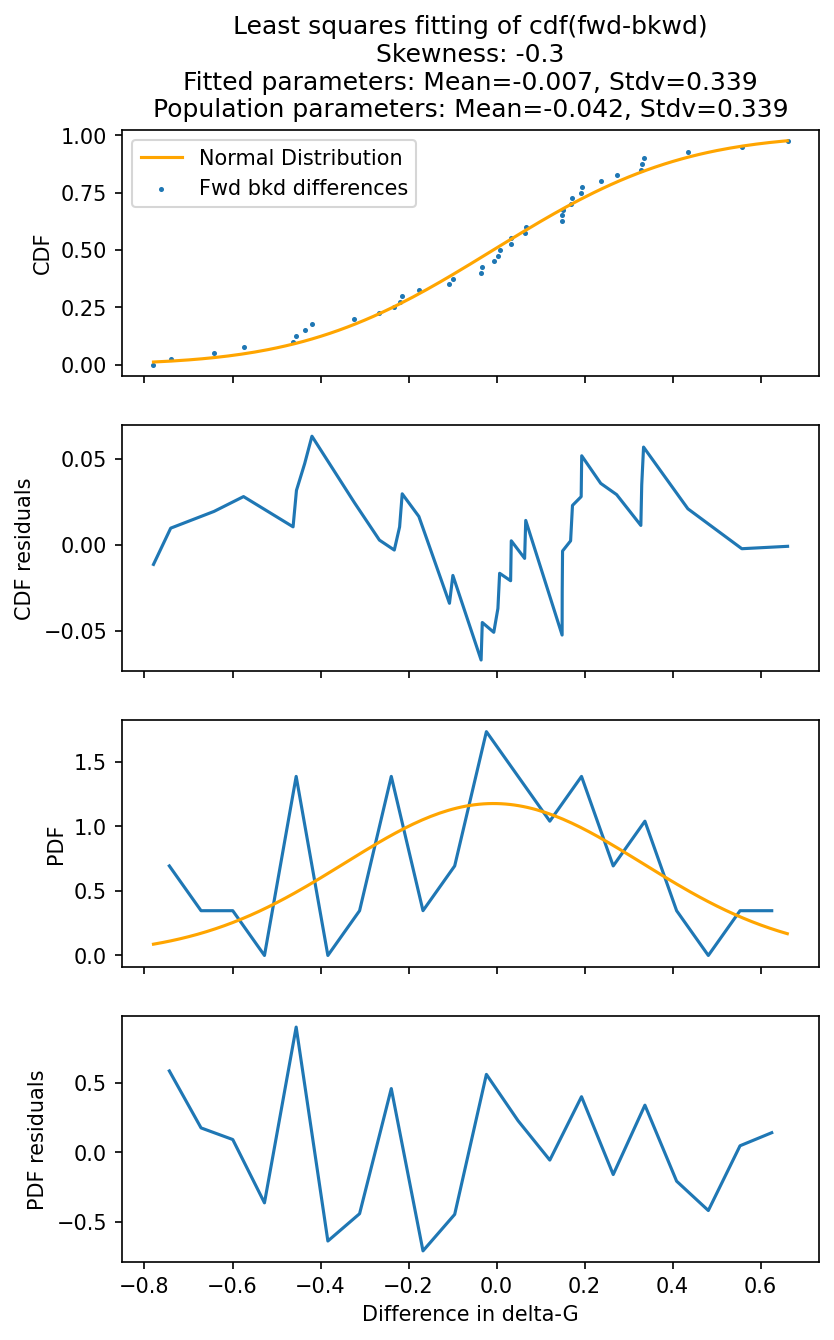

In [19]:
#fit a normal distribution to the existing data

if DiscrepancyFitting == 'LS':
    fitted = scipyFit(cumFn, X, Y)[0] #Fit norm.cdf to (X,Y)
elif DiscrepancyFitting == 'ML':
    #fitted = scipyFit(pdfFn, X, Y)[0]
    fitted = norm.fit(X) # fit a normal distribution to X
else:
    raise("Error: Discrepancy fitting code not known. Acceptable values: ML or LS")
discrepancies = dG_f + np.array(dG_b)

dx = 0.01
cdfXnorm  = np.arange(np.min(X), np.max(X), dx)
cdfYnorm = norm.cdf(cdfXnorm, fitted[0], fitted[1])
cdfYexpected = norm.cdf(X, fitted[0], fitted[1])

#plot the data as they are (estimate the CDF) and the fitted cdf
fig, (cdfAx, cdfResid, pdfAx, pdfResid) = plt.subplots(4, 1, sharex=True)
plt.xlabel('Difference in delta-G')

cdfAx.scatter(X, Y, 2, label="Fwd bkd differences")
cdfAx.plot(cdfXnorm, cdfYnorm, label="Normal Distribution", color="orange")
cdfAx.set_ylabel("CDF")
cdfAx.legend()

#cdf Residuals
cdfResiduals = Y-cdfYexpected
cdfResid.plot(X, cdfResiduals)
cdfResid.set_ylabel("CDF residuals")

#pdf
dx = 0.01
dx = 0.01

binNum = 20
window = binNum
pdfY, pdfX = np.histogram(discrepancies, bins=binNum, density=True)
pdfX = (pdfX[1:]+pdfX[:-1])/2

pdfXnorm  = np.arange(np.min(X), np.max(X), dx)
pdfYnorm = norm.pdf(pdfXnorm, fitted[0], fitted[1])

pdfYexpected = norm.pdf(pdfX, fitted[0], fitted[1])

pdfAx.plot(pdfX, pdfY,  label="Estimated Distribution")
pdfAx.set_ylabel("PDF")
pdfAx.plot(pdfXnorm, pdfYnorm, label="Fitted Normal Distribution", color="orange")

#pdf residuals
pdfResiduals = pdfY-pdfYexpected
pdfResid.plot(pdfX, pdfResiduals)
pdfResid.set_ylabel("PDF residuals") 


fig.set_figheight(10)
if DiscrepancyFitting == 'LS':
    cdfAx.title.set_text(f"Least squares fitting of cdf(fwd-bkwd)\nSkewness: {np.round(skew(X),2)}\nFitted parameters: Mean={np.round(fitted[0],3)}, Stdv={np.round(fitted[1],3)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X),3)}")
    plt.savefig(f"{path}LeastSquaresCDF{affix}.png", dpi=600)
elif DiscrepancyFitting == 'ML':
    cdfAx.title.set_text(f"Maximum likelihood fitting of fwd-bkwd\nFitted parameters: Mean={np.round(fitted[0],3)}, Stdv={np.round(fitted[1],3)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X),3)}")
    plt.savefig(f"{path}MaximumLikelihood{affix}.png", dpi=600)

plt.show()

# OPTIONAL DIAGNOSTICS

# For looking at FEP data as a time series. Can be useful diagnostically.

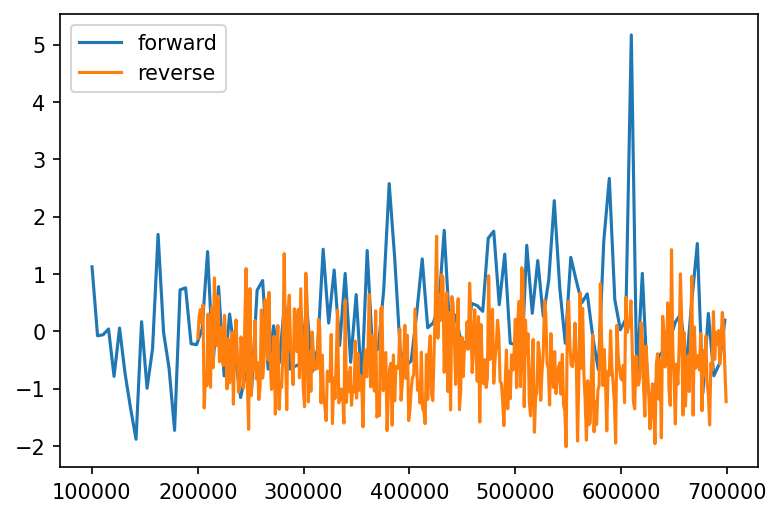

In [20]:
l = np.round(0.025*11, 3)
l2 = np.round(0.025*12, 3)
forward = u_nk.loc[(slice(None), l), l2]
plt.plot(forward.index.get_level_values(0), forward, label="forward")
reverse = -1*u_nk.loc[(slice(None), l2), l]
plt.plot(reverse.index.get_level_values(0), reverse, label="reverse")
plt.legend()

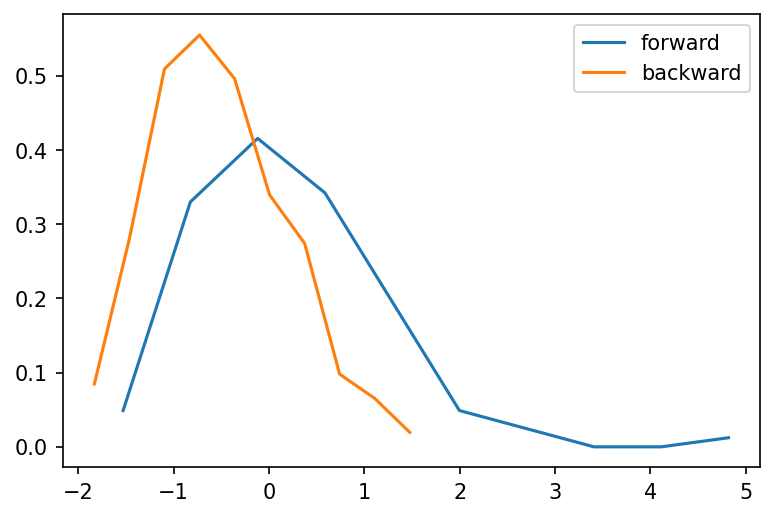

In [21]:
histF, edgesF = np.histogram(forward, density=True)
histR, edgesR = np.histogram(reverse, density=True)

plt.plot(np.mean([edgesF[1:], edgesF[:-1]], axis=0), histF, label ="forward")
plt.plot(np.mean([edgesR[1:], edgesR[:-1]], axis=0), histR, label="backward")
plt.legend()

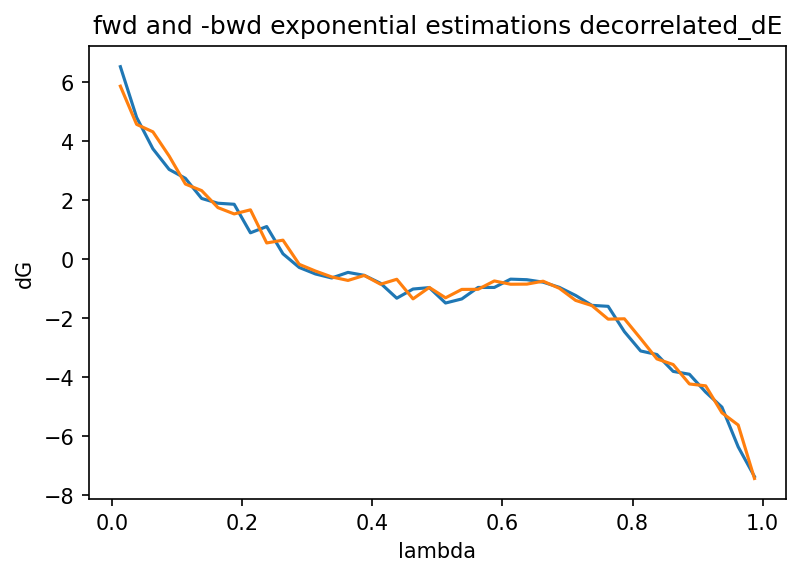

In [22]:

plt.plot(l_mid, dG_f)
plt.plot(l_mid, -dG_b)
plt.title(f"fwd and -bwd exponential estimations {affix}")
plt.xlabel("lambda")
plt.ylabel("dG")
plt.savefig(f"{path}/exponentials.png", dpi=600)

In [23]:
# Using the exponential estimator to estimate an error

In [24]:
import scipy.stats

In [25]:
errors = []
for i in np.arange(len(dG_f)):
    errors.append(scipy.stats.sem([dG_f[i], -dG_b[i]]))

In [26]:
np.linalg.norm(errors, ord=2)

1.080336380911817

In [27]:
total = 0
for x in errors:
    total += x**2
np.sqrt(total)

1.080336380911817